In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from datetime import datetime
import matplotlib.font_manager as fm
from tabulate import tabulate
import re


# 读取Excel文件
file_path = 'C:/Users/P3516/Desktop/AI项目面试试题/数据.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the data to understand its structure
data.head()

,序号,岗位名称,所属部门,企业类型,所属行业,企业人数,发展阶段,成立时间,年营业收入水平,月均薪酬,直接下属人数,其他,输出报告的评分,输出报告的评价,扣分点
0,1,开发工程师,IT部,港澳台商投资企业,煤炭开采和洗选业,20~49人,NaN,NaN,NaN,月薪<3000,下属1~2人,NaN,65.0,合格,不要有第一或者第二人称；无法确定横向部门是否描述准确；无法判断所开发的软件/系统是是否与实际一致。
1,2,数据分析,it,有限责任公司,计算机,50~99人,NaN,NaN,NaN,5000≤月薪<8000,下属0人,NaN,70.0,良好,无法确定实际是分析内部数据还是外部数据，有可能结果完全跑偏
2,3,水利工程项目经理,NaN,集体企业,水利管理业,1000~1999人,成长期（3-10年，扩张市场，增加产品）,NaN,1000≤年营收水平<2000,NaN,下属8~10人,NaN,75.0,良好,内容可以更详尽
3,4,审计主管,审计部,国有企业,石油和天然气开采业,200~299人,成长期（3-10年，扩张市场，增加产品）,NaN,30000≤年营收水平<50000（3亿~5亿）,8000≤月薪<10000,下属3~5人,负责公司审计业务,60.0,合格,对项目审计提得偏少
4,5,互联网产品项目经理,NaN,股份有限公司,互联网和相关服务,100~199人,生存期（1-3年，市场适应，现金流管理）,NaN,300≤年营收水平<500,8000≤月薪<10000,下属8~10人,NaN,75.0,良好,NaN


In [48]:
# 创建“数据完整度”列，统计每行11个企业属性中非空值的数量
enterprise_columns = ['岗位名称', '所属部门', '企业类型', '所属行业', '企业人数', '发展阶段', '成立时间', '年营业收入水平', '月均薪酬', '直接下属人数', '其他']
data['数据完整度'] = data[enterprise_columns].notna().sum(axis=1)

# 处理“年营业收入水平”列
def convert_revenue(revenue):
    if pd.isna(revenue):
        return np.nan
    revenue = re.sub(r'\(.*?\)', '', revenue)  # 去掉括号及其内容
    revenue = revenue.replace('万', '').replace('亿', '0000')
    parts = re.findall(r'\d+', revenue)
    if '≤' in revenue and '<' in revenue and len(parts) == 2:
        return (int(parts[0]) + int(parts[1])) / 2 * 10000
    elif '≥' in revenue and len(parts) == 1:
        return int(parts[0]) * 10000
    elif '<' in revenue and len(parts) == 1:
        return int(parts[0]) * 10000 / 2
    return np.nan

data['年营业收入水平'] = data['年营业收入水平'].apply(convert_revenue)

# 处理“成立时间”列
def convert_establishment_year(establishment):
    if pd.isna(establishment):
        return np.nan
    establishment = str(establishment)
    establishment = re.sub(r'\(.*?\)', '', establishment)
    parts = re.findall(r'\d+', establishment)
    if len(parts) == 2:
        return (int(parts[0]) + int(parts[1])) / 2
    elif len(parts) == 1:
        return int(parts[0])
    return np.nan

data['成立时间'] = data['成立时间'].apply(convert_establishment_year)

# 获取当前年份
current_year = datetime.now().year

# 函数：将区间转换为中间值，处理带有符号和固定值的情况
def convert_range_to_median(value):
    if pd.isna(value):
        return np.nan
    value = value.replace('人', '').replace('年营收水平', '').replace('下属', '').replace('月薪', '').replace('以上', '').replace('万', '0000').replace('亿', '00000000')
    if '（' in value and '）' in value:
        value = value.split('（')[0]
    if '≤' in value or '<' in value or '≥' in value or '~' in value:
        value = value.replace('≤', '~').replace('<', '~').replace('≥', '~').replace('~~', '~')
        ranges = value.split('~')
        if len(ranges) == 2:
            try:
                if ranges[0].strip() == '':
                    return float(ranges[1].strip()) / 2
                elif ranges[1].strip() == '':
                    return float(ranges[0].strip()) / 2
                else:
                    return (float(ranges[0].strip()) + float(ranges[1].strip())) / 2
            except ValueError:
                return np.nan
    try:
        return float(value.strip())
    except ValueError:
        return np.nan

# 对企业人数、月均薪酬、直接下属人数进行转换
data['企业人数'] = data['企业人数'].apply(convert_range_to_median).round().astype('Int64')
data['月均薪酬'] = data['月均薪酬'].apply(convert_range_to_median)
data['直接下属人数'] = data['直接下属人数'].apply(convert_range_to_median).round().astype('Int64')

# 用中位数填充数值列中的缺失值
data_filled = data.fillna({
    '企业人数': data['企业人数'].median(),
    '月均薪酬': data['月均薪酬'].median(),
    '直接下属人数': data['直接下属人数'].median(),
    '年营业收入水平': data['年营业收入水平'].median(),
    '成立时间': data['成立时间'].median()
})

# 将文本属性中的空值填充为 '未知'
text_columns = ['岗位名称', '所属部门', '企业类型', '所属行业', '发展阶段']
data_filled[text_columns] = data_filled[text_columns].fillna('未知')

# 删除目标列 "输出报告的评分" 中包含缺失值的行
data_filled = data_filled.dropna(subset=['输出报告的评分'])

# 创建“其他”属性的二进制列，若“其他”列有文本内容，则标记为1，否则为0
data_filled['其他'] = data['其他'].apply(lambda x: 1 if pd.notna(x) else 0)

# 调整列的顺序，将“数据完整度”放在“其他”和“输出报告的评分”之间
cols = data_filled.columns.tolist()
cols.insert(cols.index('输出报告的评分'), cols.pop(cols.index('数据完整度')))
data_filled = data_filled[cols]

# 以Markdown格式输出处理后的前几行数据
md_table = tabulate(data_filled.head(), headers='keys', tablefmt='pipe', showindex=False)

# 使用 Markdown 输出表格
from IPython.display import Markdown, display
display(Markdown(md_table))

# 保存处理后的数据到原数据的同一目录
output_file_path = 'C:/Users/P3516/Desktop/AI项目面试试题/处理后的数据_完整度.xlsx'
data_filled.to_excel(output_file_path, index=False)  # 保存为Excel文件

# 输出处理后的数据表格
print(f"处理后的数据已保存为 Excel 文件: {output_file_path}")


|   序号 | 岗位名称           | 所属部门   | 企业类型         | 所属行业           |   企业人数 | 发展阶段                              |   成立时间 |   年营业收入水平 |   月均薪酬 |   直接下属人数 |   其他 |   数据完整度 |   输出报告的评分 | 输出报告的评价   | 扣分点                                                                                            |
|-------:|:-------------------|:-----------|:-----------------|:-------------------|-----------:|:--------------------------------------|-----------:|-----------------:|-----------:|---------------:|-------:|-------------:|-----------------:|:-----------------|:--------------------------------------------------------------------------------------------------|
|      1 | 开发工程师         | IT部       | 港澳台商投资企业 | 煤炭开采和洗选业   |         34 | 未知                                  |          8 |          7.5e+06 |       1500 |              2 |      0 |            7 |               65 | 合格             | 不要有第一或者第二人称；无法确定横向部门是否描述准确；无法判断所开发的软件/系统是是否与实际一致。 |
|      2 | 数据分析           | it         | 有限责任公司     | 计算机             |         74 | 未知                                  |          8 |          7.5e+06 |       6500 |              0 |      0 |            7 |               70 | 良好             | 无法确定实际是分析内部数据还是外部数据，有可能结果完全跑偏                                        |
|      3 | 水利工程项目经理   | 未知       | 集体企业         | 水利管理业         |       1500 | 成长期（3-10年，扩张市场，增加产品）  |          8 |          1.5e+07 |       9000 |              9 |      0 |            7 |               75 | 良好             | 内容可以更详尽                                                                                    |
|      4 | 审计主管           | 审计部     | 国有企业         | 石油和天然气开采业 |        250 | 成长期（3-10年，扩张市场，增加产品）  |          8 |          7.5e+06 |       9000 |              4 |      1 |           10 |               60 | 合格             | 对项目审计提得偏少                                                                                |
|      5 | 互联网产品项目经理 | 未知       | 股份有限公司     | 互联网和相关服务   |        150 | 生存期（1-3年，市场适应，现金流管理） |          8 |          4e+06   |       9000 |              9 |      0 |            8 |               75 | 良好             | nan                                                                                               |

处理后的数据已保存为 Excel 文件: C:/Users/P3516/Desktop/AI项目面试试题/处理后的数据_完整度.xlsx


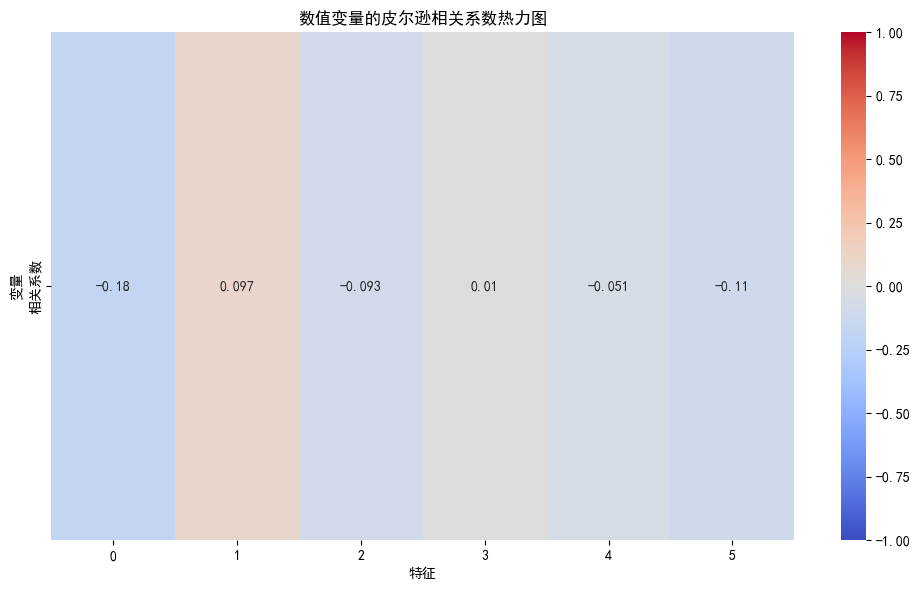

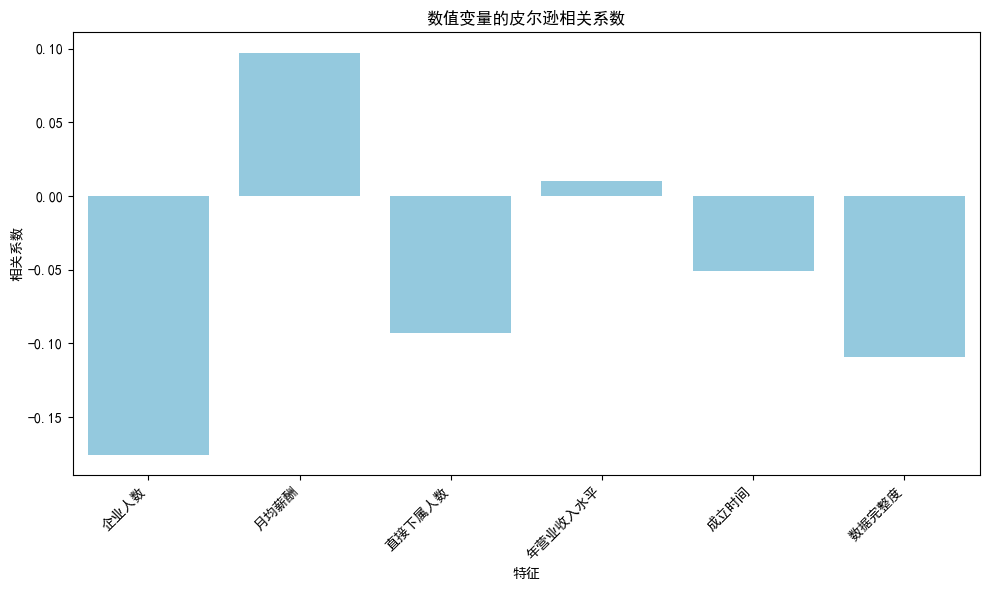

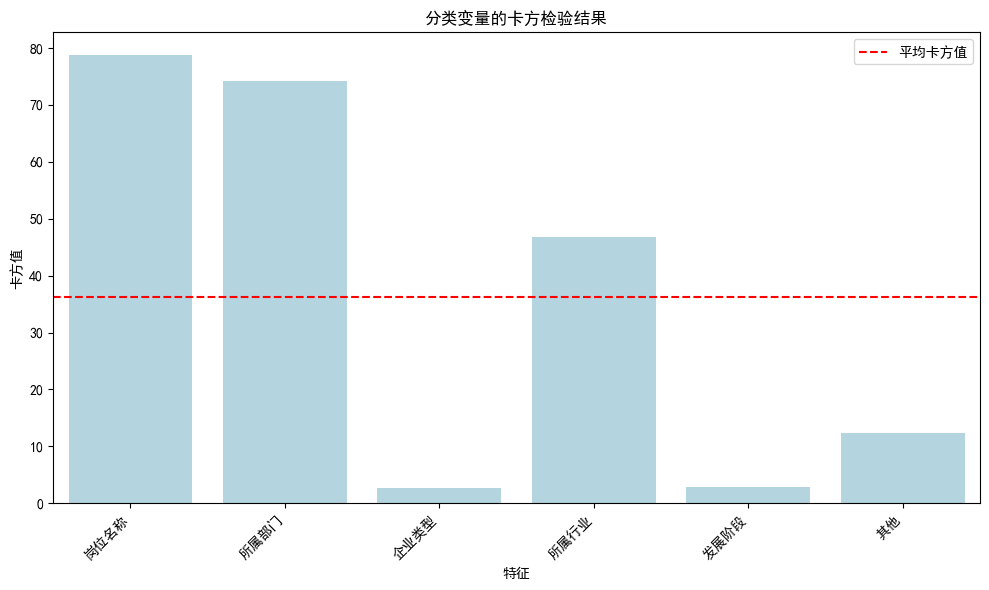


皮尔逊相关系数结果（数值变量）:

| 特征           |   相关系数 |
|:---------------|-----------:|
| 企业人数       | -0.175439  |
| 月均薪酬       |  0.0972891 |
| 直接下属人数   | -0.0930694 |
| 年营业收入水平 |  0.0103919 |
| 成立时间       | -0.0508796 |
| 数据完整度     | -0.109099  |

卡方检验结果（分类变量）:

| 特征     |   卡方值 |         p值 |
|:---------|---------:|------------:|
| 岗位名称 | 78.7943  | 2.42575e-14 |
| 所属部门 | 74.2558  | 2.03073e-13 |
| 企业类型 |  2.66774 | 0.913946    |
| 所属行业 | 46.7941  | 6.12271e-08 |
| 发展阶段 |  2.94077 | 0.890427    |
| 其他     | 12.3648  | 0.0891839   |


In [39]:
# 解决中文字体显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

# 1. 数值变量的皮尔逊相关系数计算
numeric_columns = ['企业人数', '月均薪酬', '直接下属人数', '年营业收入水平', '成立时间', '数据完整度']
correlations = {}

for col in numeric_columns:
    corr, _ = pearsonr(data_filled[col], data_filled['输出报告的评分'])
    correlations[col] = corr

# 将结果转化为DataFrame
corr_df = pd.DataFrame(list(correlations.items()), columns=['特征', '相关系数'])

# 可视化：皮尔逊相关系数的热力图
plt.figure(figsize=(10, 6))
sns.heatmap(corr_df[['相关系数']].T, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('数值变量的皮尔逊相关系数热力图')
plt.xlabel('特征')
plt.ylabel('变量')  # 避免重复的“相关系数”标签
plt.tight_layout()
plt.show()

# 可视化：皮尔逊相关系数的条形图
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_df['特征'], y=corr_df['相关系数'], color='skyblue')  # 用 color 而不是 palette
plt.title('数值变量的皮尔逊相关系数')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. 分类变量的卡方检验
categorical_columns = ['岗位名称', '所属部门', '企业类型', '所属行业', '发展阶段', '其他']
le = LabelEncoder()
X_categorical_encoded = data_filled[categorical_columns].apply(le.fit_transform)
chi2_scores, p_values = chi2(X_categorical_encoded, data_filled['输出报告的评分'])

# 将卡方检验结果转化为DataFrame
chi2_df = pd.DataFrame({
    '特征': categorical_columns,
    '卡方值': chi2_scores,
    'p值': p_values
})
    
# 可视化：卡方检验的条形图
plt.figure(figsize=(10, 6))
sns.barplot(x=chi2_df['特征'], y=chi2_df['卡方值'], color='lightblue')  # 用 color 而不是 palette
plt.title('分类变量的卡方检验结果')
plt.axhline(chi2_df['卡方值'].mean(), color='r', linestyle='--', label='平均卡方值')
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 输出表格格式
print("\n皮尔逊相关系数结果（数值变量）:\n")
print(tabulate(corr_df, headers='keys', tablefmt='pipe', showindex=False))

print("\n卡方检验结果（分类变量）:\n")
print(tabulate(chi2_df, headers='keys', tablefmt='pipe', showindex=False))

最佳参数: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
均方误差（MSE）: 123.93023846153848
决定系数（R²）: -0.5013770824372763


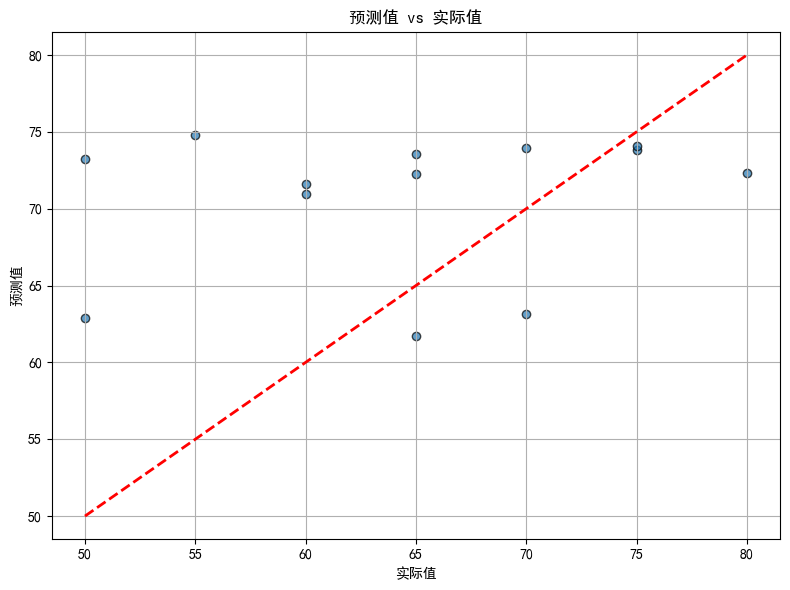

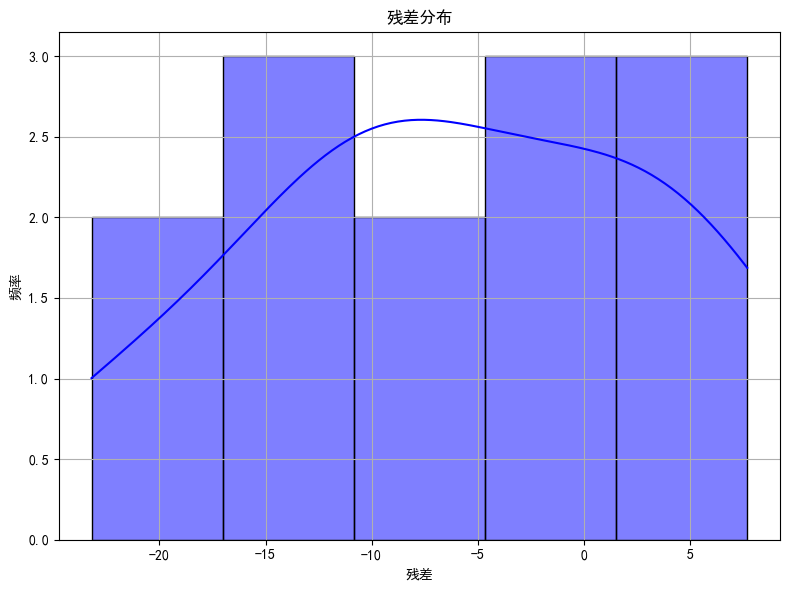

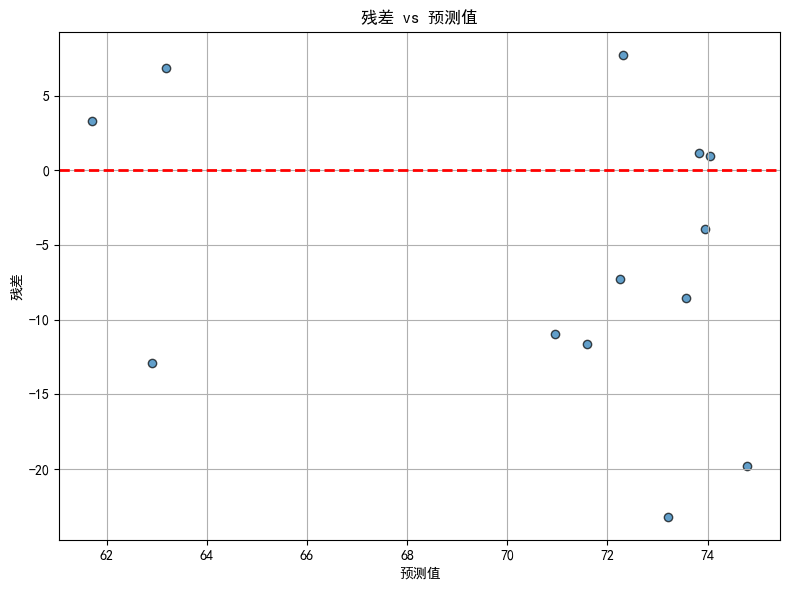

In [42]:
# 导入库
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 提取输入特征
X = data_filled[['企业人数', '月均薪酬', '数据完整度', '岗位名称', '所属部门', '所属行业']]

# 将分类变量进行编码
X = pd.get_dummies(X, columns=['岗位名称', '所属部门', '所属行业'], drop_first=True)

# 目标变量
y = data_filled['输出报告的评分']

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义超参数网格
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# 使用GridSearchCV进行超参数搜索
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 输出最佳参数
print("最佳参数:", grid_search.best_params_)

# 使用最佳参数重新训练模型
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# 模型预测
y_pred = best_rf.predict(X_test)

# 计算性能指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"均方误差（MSE）: {mse}")
print(f"决定系数（R²）: {r2}")

# ------------------- 数据可视化 -------------------

# 1. 可视化：预测值 vs 实际值
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('预测值 vs 实际值')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. 可视化：残差图
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('残差分布')
plt.xlabel('残差')
plt.ylabel('频率')
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 可视化：残差与预测值的关系
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, edgecolor='k', alpha=0.7)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('预测值')
plt.ylabel('残差')
plt.title('残差 vs 预测值')
plt.grid(True)
plt.tight_layout()
plt.show()


均方误差（MSE）: 117.04459875957437
决定系数（R²）: -0.4179596552235174


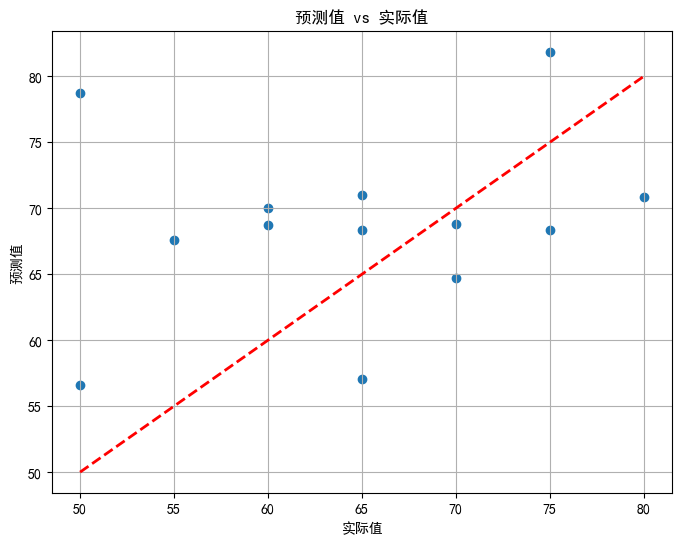

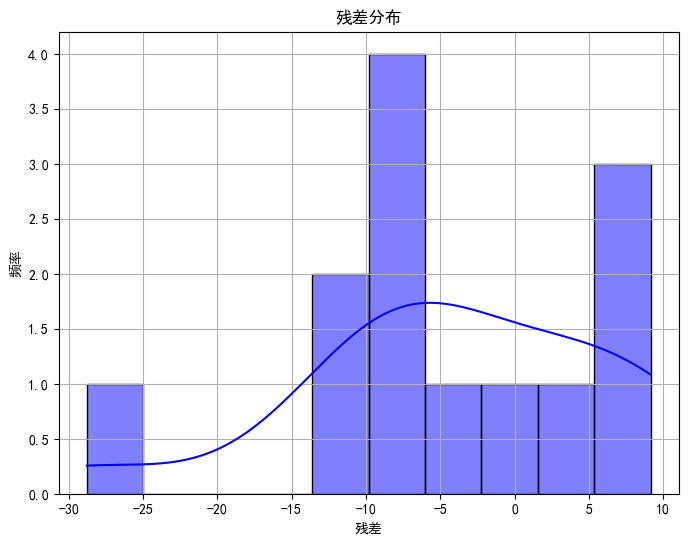

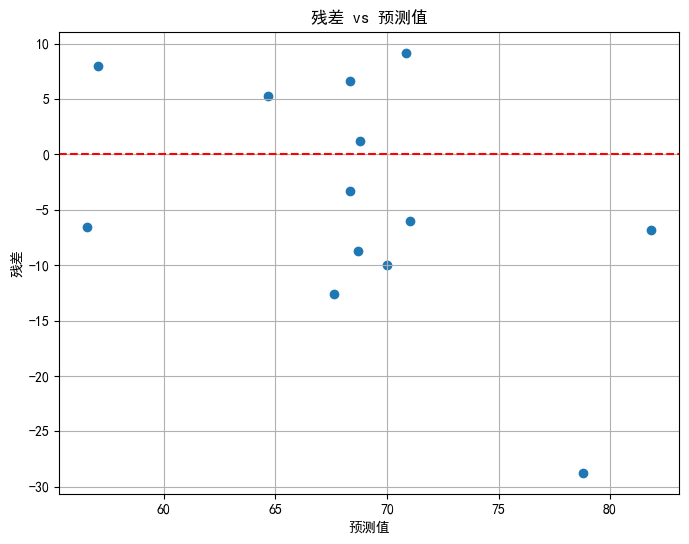

In [34]:
# 导入线性回归模型
from sklearn.linear_model import LinearRegression

# 提取输入特征，包括7个特征
X = data_filled[['企业人数', '月均薪酬', '岗位名称', '所属部门', '所属行业', '数据完整度', '其他']]

# 将分类变量进行编码
X = pd.get_dummies(X, columns=['岗位名称', '所属部门', '所属行业'], drop_first=True)

# 目标变量
y = data_filled['输出报告的评分']

# 分割数据集（80%训练，20%测试）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化线性回归模型
lr = LinearRegression()

# 模型训练
lr.fit(X_train, y_train)

# 模型预测
y_pred = lr.predict(X_test)

# 计算性能指标
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"均方误差（MSE）: {mse}")
print(f"决定系数（R²）: {r2}")

# 数据可视化：真实值 vs 预测值
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('预测值 vs 实际值')
plt.grid(True)
plt.show()

# 残差分布
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='blue', bins=10)
plt.title('残差分布')
plt.xlabel('残差')
plt.ylabel('频率')
plt.grid(True)
plt.show()

# 残差图
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('预测值')
plt.ylabel('残差')
plt.title('残差 vs 预测值')
plt.grid(True)
plt.show()


In [45]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# 提取输入特征
X = data_filled[['企业人数', '月均薪酬', '数据完整度', '岗位名称', '所属部门', '所属行业']]
X = pd.get_dummies(X, columns=['岗位名称', '所属部门', '所属行业'], drop_first=True)

# 目标变量
y = data_filled['输出报告的评分']

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化岭回归模型
ridge = Ridge(alpha=1.0)

# 训练模型
ridge.fit(X_train, y_train)

# 预测
y_pred_ridge = ridge.predict(X_test)

# 计算性能指标
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"岭回归 - 均方误差（MSE）: {mse_ridge}")
print(f"岭回归 - 决定系数（R²）: {r2_ridge}")


岭回归 - 均方误差（MSE）: 129.3329115853648
岭回归 - 决定系数（R²）: -0.5668288213567492


In [46]:
from sklearn.ensemble import GradientBoostingRegressor

# 初始化梯度提升回归模型
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# 训练模型
gbr.fit(X_train, y_train)

# 预测
y_pred_gbr = gbr.predict(X_test)

# 计算性能指标
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f"梯度提升决策树 - 均方误差（MSE）: {mse_gbr}")
print(f"梯度提升决策树 - 决定系数（R²）: {r2_gbr}")


梯度提升决策树 - 均方误差（MSE）: 117.29805580525736
梯度提升决策树 - 决定系数（R²）: -0.42103021011387054
